In [30]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [31]:
IMAGE_SIZE =256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [32]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [33]:
class_names=dataset.class_names

In [57]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [59]:
class_names[1]

'Potato___Late_blight'

In [34]:
len(dataset)

68

In [35]:
for x,y in dataset.take(1):
    #print(x.shape)
    print(x)#it explain the 32 photos(features)
    print (y)
    
    #x represents the input features.{input}
#y represents the labels.{output}
#dataset.take(1) returns a new dataset containing only 1 batch (or sample) from the original dataset.


tf.Tensor(
[[[[142. 116. 117.]
   [137. 111. 112.]
   [107.  81.  82.]
   ...
   [173. 155. 151.]
   [182. 164. 160.]
   [196. 178. 174.]]

  [[138. 112. 113.]
   [137. 111. 112.]
   [132. 106. 107.]
   ...
   [175. 157. 153.]
   [177. 159. 155.]
   [185. 167. 163.]]

  [[117.  91.  92.]
   [112.  86.  87.]
   [144. 118. 119.]
   ...
   [176. 158. 154.]
   [176. 158. 154.]
   [181. 163. 159.]]

  ...

  [[107.  81.  80.]
   [146. 120. 119.]
   [126. 100.  99.]
   ...
   [163. 143. 142.]
   [167. 147. 146.]
   [171. 151. 150.]]

  [[115.  89.  88.]
   [124.  98.  97.]
   [160. 134. 133.]
   ...
   [161. 141. 140.]
   [165. 145. 144.]
   [169. 149. 148.]]

  [[116.  90.  89.]
   [136. 110. 109.]
   [137. 111. 110.]
   ...
   [158. 138. 137.]
   [161. 141. 140.]
   [164. 144. 143.]]]


 [[[169. 155. 154.]
   [138. 124. 123.]
   [163. 149. 148.]
   ...
   [136. 110. 109.]
   [142. 116. 115.]
   [128. 102. 101.]]

  [[167. 153. 152.]
   [152. 138. 137.]
   [148. 134. 133.]
   ...
   [106.  

'The astype("uint8") converts the data type of the image to unsigned 8-bit integers.\nImage data is often stored in various formats:\nFloat32 (values between 0 and 1).\nInt32 or other numeric types.\nMatplotlib requires pixel values to be in the range [0, 255] for displaying RGB images, which is the range of uint8.'

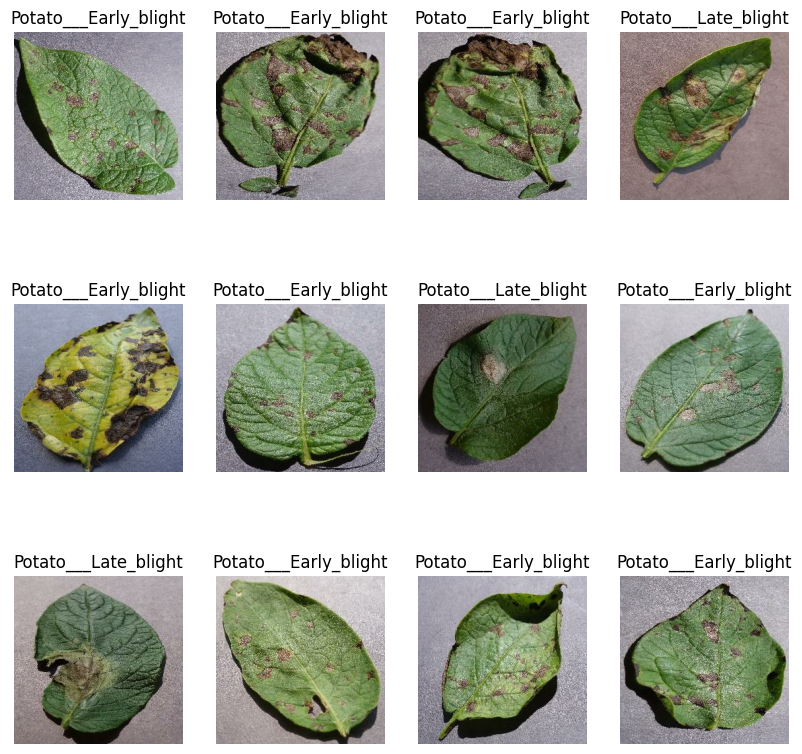

In [36]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
       ax = plt.subplot(3,4,i+1)
       plt.imshow(image_batch[i].numpy().astype("uint8"))
       plt.title(class_names[label_batch[i]])
       plt.axis('off')
'''The astype("uint8") converts the data type of the image to unsigned 8-bit integers.
Image data is often stored in various formats:
Float32 (values between 0 and 1).
Int32 or other numeric types.
Matplotlib requires pixel values to be in the range [0, 255] for displaying RGB images, which is the range of uint8.'''
  

In [37]:
#Function to Split Dataset
len(dataset)


68

In [38]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [39]:
train_ds = dataset.take(54)
len(train_ds)

54

In [40]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [41]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [42]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [43]:
test_ds = test_ds.skip(6)
len(test_ds)

8

data participation

In [44]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [45]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [46]:
len(train_ds)

54

In [47]:
#improve the performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [48]:
#normalize the data
from keras.layers import Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255),
])

Old and new API	New API
keras.layers.experimental.preprocessing.Normalization	keras.layers.Normalization
keras.layers.experimental.preprocessing.Rescaling	keras.layers.Rescaling
keras.layers.experimental.preprocessing.StringLookup	keras.layers.StringLookup
keras.layers.experimental.preprocessing.IntegerLookup	keras.layers.IntegerLookup
keras.layers.experimental.preprocessing.TextVectorization	
keras.layers.TextVectorization

In [49]:
#data argumentation - softmax -it will normalize the probability of the classes
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

model architecture

In [50]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
# explicitly initializes the model with the given 
# input shape, avoiding the need for lazy  initialization
# (like during fit() or predict()).

#It’s especially useful for debugging, inspecting the 
# architecture with model.summary(), or 
# ensuring custom layers in subclassed models are initialized.

c:\Users\Jegan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [54]:
model.fit(
    train_ds,
    epochs =EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
          )

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7142 - loss: 0.6265 - val_accuracy: 0.7552 - val_loss: 0.4809
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8413 - loss: 0.3784 - val_accuracy: 0.8854 - val_loss: 0.2939
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9072 - loss: 0.2451 - val_accuracy: 0.9115 - val_loss: 0.2119
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9004 - loss: 0.2634 - val_accuracy: 0.8854 - val_loss: 0.3353
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9253 - loss: 0.1866 - val_accuracy: 0.9531 - val_loss: 0.1140
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9535 - loss: 0.1269 - val_accuracy: 0.8490 - val_loss: 0.3233
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9332 - loss: 0.1666 - val_accuracy: 0.9479 - val_loss: 0.1116
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9636 - loss: 0.0993 - val_accuracy: 0.9427 - val

In [55]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 312ms/step - accuracy: 0.9974 - loss: 0.0195


[0.02833024226129055, 0.99609375]

Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Potato___Late_blight


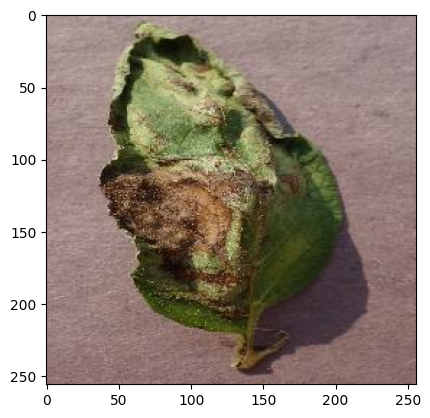

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


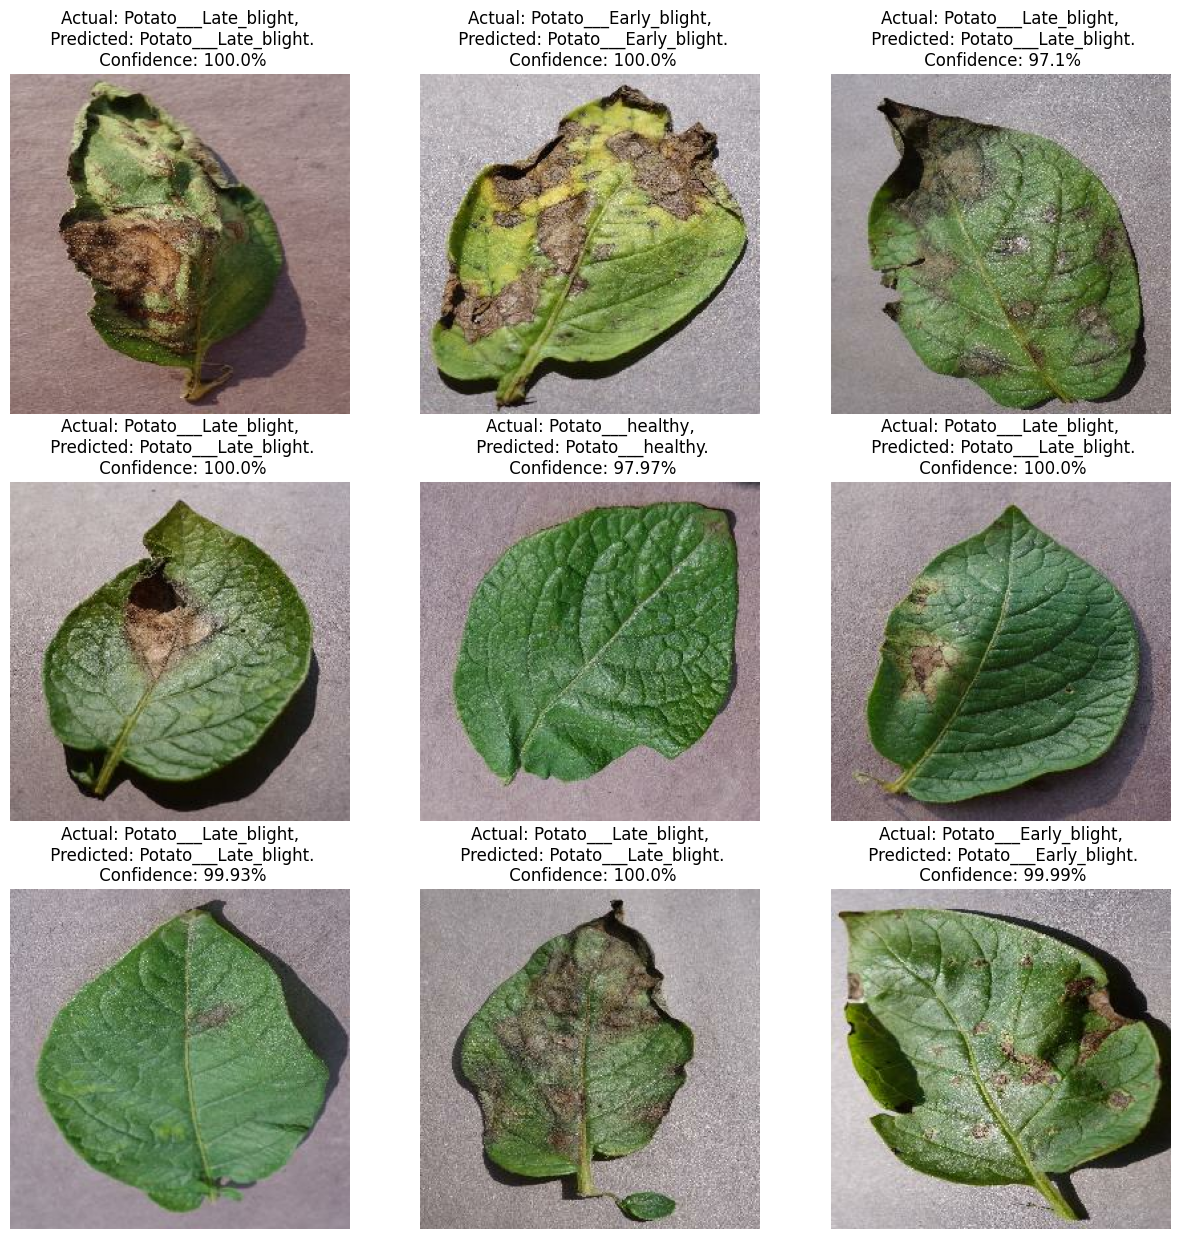

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=../models/1.